# Measurement Error in Exogenous Variables

> How to account for the observation process

Measurement error in exogenous variables—those not influenced by other variables in a model—can significantly compromise the integrity of regression analyses. When these variables are inaccurately measured and the errors are not properly addressed, several issues may arise:

- **Attenuation Bias**: This occurs when measurement errors lead to biased and inconsistent parameter estimates, typically causing the estimated coefficients to be closer to zero than their true values. [(Wikipedia)](https://en.wikipedia.org/wiki/Regression_dilution)
- **Reduced Statistical Power**: Measurement errors increase the variance of estimators, making it more challenging to detect significant relationships between variables.
- **Misleading Inferences**: Ignoring measurement errors can result in incorrect conclusions about the relationships between variables, potentially leading to flawed policy decisions or interpretations.

This website is dedicated to exploring the challenges posed by measurement errors in exogenous variables within regression models. We provide comprehensive insights into how these errors can distort results and discuss effective strategies to mitigate their impact.

By understanding and addressing measurement errors in exogenous variables, data scientists can enhance the validity and reliability of their regression analyses.

In [2]:
#| default_exp measurement_error

In [3]:
#| hide
from nbdev.showdoc import *

In [4]:
#| export
#| hide
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymc as pm
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
import xarray as xr
from tueplots import bundles
from tueplots.constants.color import rgb
from common_regression_issues.utils.plotting import rgb_to_hex

In [5]:
#| hide
plt.rcParams.update(bundles.beamer_moml())
plt.rcParams.update({'figure.dpi': 300})
plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']

## Survey Data

When analyzing survey data, it’s crucial to assess the precision of population parameter estimates. This precision is influenced by factors such as sample size, sampling design, and measurement error within the survey data.

## Impact of Measurement Error on Regression Models

Incorporating imprecise measurements into regression models can lead to biased and inconsistent coefficient estimates. This issue persists even with unbiased sampling designs and accurate respondent answers. In survey research, where sample sizes are often limited and sampling designs complex, measurement errors can significantly affect the precision of population parameter estimates.

:::{#exm-binary-outcome}
## Random Measurement Error in a Binary Outcome Variable

Consider a weekly survey involving approximately 500 participants, selected randomly to represent the general population. Participants are asked if they recall seeing a specific brand’s advertisement, with data collected via phone and online methods.

Assuming perfect recall accuracy, we aim to estimate the effect of advertisement recall on the brand’s sales using a simple linear regression model. To explore this, we can simulate three years of survey data to analyze the relationship between advertisement recall and sales.
:::

:::{.callout-tip collapse="true"}
## Helper Functions

In [6]:
#| export
def random_walk_awareness_model(
  periods: list | pd.DatetimeIndex | np.ndarray, # Time periods to simulate
  ) -> pm.Model: # PyMC model for the random walk awareness model
    coords = {
      'Period': periods,
    }
    with pm.Model(coords = coords) as model:
        #Random walk model
        weekly_variation = pm.HalfNormal('weekly_variation', sigma=.1)
        initial_awareness = pm.Normal('initial_awareness', mu=0, sigma=1)
        logit_awareness = pm.GaussianRandomWalk(
          'logit_awareness', 
          sigma=weekly_variation, 
          init_dist=pm.Normal.dist(mu=initial_awareness, sigma=.01), 
          dims="Period")
        
        weekly_shock = pm.HalfNormal('weekly_shock', sigma=.1)
        _noise = pm.Normal('_noise', mu=0, sigma=1, dims="Period")
        awareness = pm.Deterministic('awareness', pm.math.invlogit(logit_awareness + weekly_shock*_noise), dims="Period")
    return model

In [7]:
dates = pd.date_range(start='2021-01-01', periods=156, freq='W-MON')
awareness_model = random_walk_awareness_model(dates)
starting_awareness = 0.025
logit_starting_awareness = np.log(starting_awareness/(1-starting_awareness))
generative_model = pm.do(
  awareness_model, 
  {
    'weekly_variation': .1, 
    'initial_awareness': logit_starting_awareness,
    'weekly_shock': .01
  }
)
population_awareness = pm.draw(generative_model['awareness'], random_seed=23)
population_awareness = xr.DataArray(
  population_awareness,
  dims=['Period'],
  coords={'Period': dates}
)

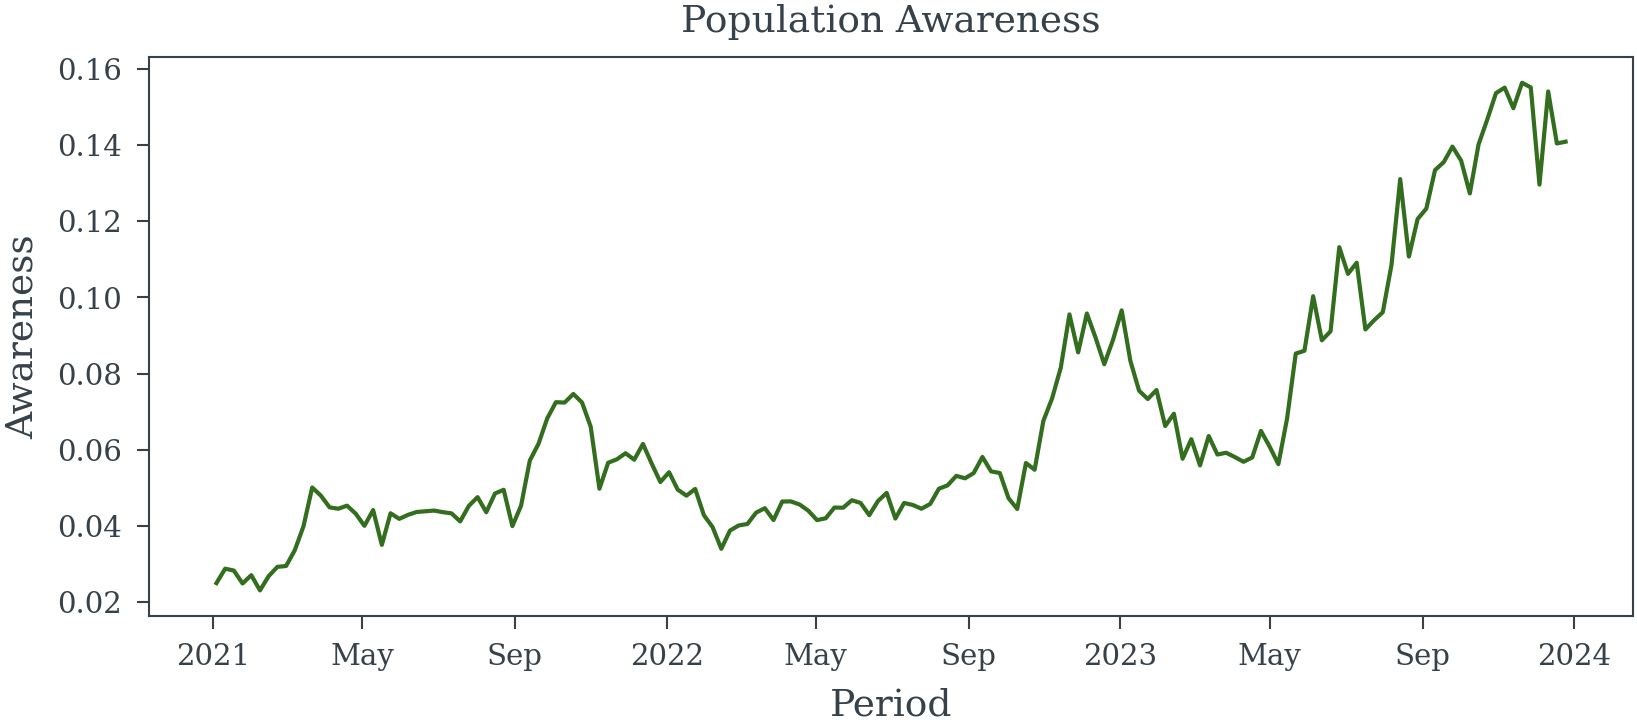

In [8]:
#| echo: false
#| label: fig-population-awareness
#| fig-cap: Population Awareness
#plt.figure(figsize=(10, 5))
population_awareness.plot(c=rgb_to_hex(rgb.tue_darkgreen*256))
plt.title('Population Awareness')
plt.ylabel('Awareness')
plt.xlabel('Period');

In [9]:
#| export
def survey_obs_model(
  population_awareness: xr.DataArray | pm.pytensorf.TensorVariable, # Population awareness
  avg_weekly_participants: float = 500.0, # Average number of participants per week
  coords: dict = None, # Coordinates for the PyMC model
  model: pm.Model = None, # PyMC model to add the survey observation model
  ) -> pm.Model:
    if coords is None:
      assert isinstance(population_awareness, xr.DataArray), "If coords is not provided, population_awareness must be an xarray DataArray"
      coords = {
        'Period': population_awareness['Period'].values,
      }
      population_awareness = population_awareness.values
    try:
      model = pm.modelcontext(model)
    except TypeError:
      model = pm.Model(coords=coords)
    with model:
        N_survey_participant = pm.Poisson('n_survey_participants', avg_weekly_participants, dims="Period")
        N_positive = pm.Binomial('n_positive', N_survey_participant, population_awareness, dims="Period")
    return model

In [10]:
#| export
def simulate_awareness_survey_data(
  start_date: str = '2020-01-01', # Start date of the survey data
  n_weeks: int = 156, # Number of weeks to simulate
  avg_weekly_participants: float = 500.0, # Average number of participants per week
  weekly_awareness_variation: float = 0.08, # Std. dev. of gaussian inovations for weekly awareness
  starting_population_aware: float = 0.025, # Starting population awareness
  weekly_shock: float = 0.01, # Std. dev. of gaussian noise for weekly deviation from random walk
  random_seed: int = 42, # Random seed for reproducibility
) -> xr.Dataset: # Simulated awareness survey data as an xarray dataset
  dates = pd.date_range(start=start_date, periods=n_weeks, freq='W-MON')
  awareness_model = random_walk_awareness_model(dates)
  gen_model = pm.do(
    awareness_model, 
    {
      'weekly_variation': weekly_awareness_variation, 
      'initial_awareness': np.log(starting_population_aware/(1-starting_population_aware)),
      'weekly_shock': .01
    }
  )
  
  with gen_model:
    survey_obs_model(gen_model['awareness'], avg_weekly_participants=avg_weekly_participants, coords={'Period': dates})
    trace = pm.sample_prior_predictive(1, random_seed=random_seed)
  
  trace = trace.prior.isel(chain=0, draw=0).drop_vars('chain').drop_vars('draw')
  return trace.assign(estimated_awareness = trace['n_positive']/trace['n_survey_participants'])


In [11]:
#| export
def plot_survey_sim_data(
  data: xr.Dataset, # Simulated survey data must contain 'awareness' and 'estimated_awareness' variables
) -> None: # Plot of the simulated survey data
    #plt.figure(figsize=(10, 5))
    data.estimated_awareness.plot.scatter(x='Period', color=rgb_to_hex(rgb.tue_gray*256), label='Simulated Survey Data')
    data.awareness.plot(color=rgb_to_hex(rgb.tue_darkgreen*256), ls='--', label="Population Awareness")
    plt.legend()
    plt.title('Simulated Awareness Survey Data');

:::

## Simulation Approach

1.	**Data Generation**: Create a dataset representing weekly survey responses over three years, including variables for advertisement recall (binary) and corresponding sales figures.
2.	**Model Specification**: Define a linear regression model with sales as the dependent variable and advertisement recall as the independent variable.
3.	**Analysis**: Fit the model to the simulated data to assess the estimated effect of advertisement recall on sales.

#### Generate Survey Responses

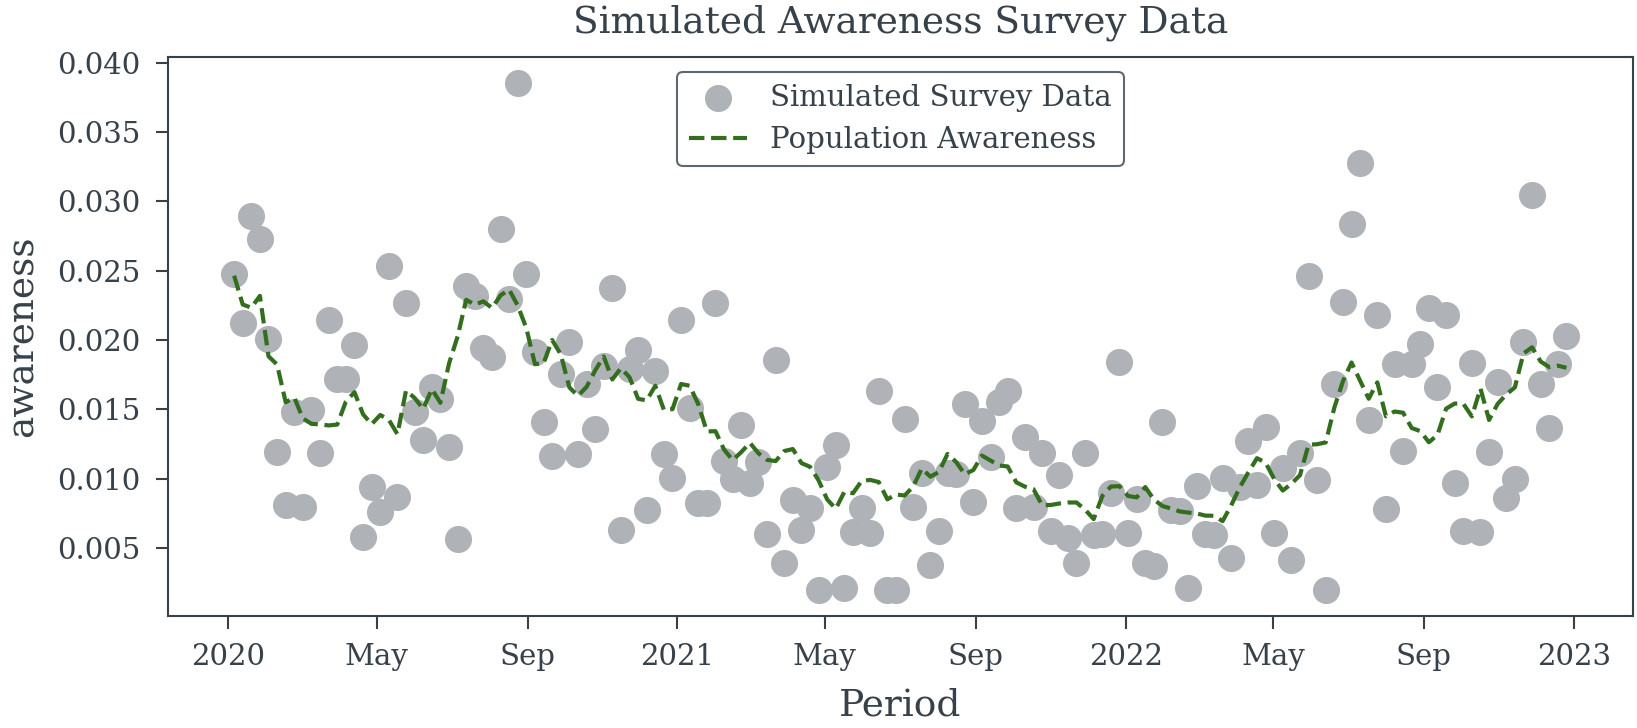

In [12]:
#| label: fig-survey-sim-data
#| fig-cap: Simulated Awareness Survey Data
trace = simulate_awareness_survey_data(random_seed=23)
plot_survey_sim_data(trace)

#### Generate Sales Data

The sales data is simulated using the following equation:

$$
\begin{align*}
log(S_t) &= \beta \text{pop\_awareness}_t + \alpha + \varepsilon_t \\
\varepsilon_t &\sim \mathcal{N}(0, \sigma^2)
\end{align*}
$${#eq-sales}

Lets see if the true coeff $\beta$ can be estimated using the simulated data.

In [15]:
ACTUAL_AWARENESS_COEFF = 30
log_sales = trace.awareness*ACTUAL_AWARENESS_COEFF + 10 + np.random.normal(0, 0.03, trace.awareness.shape)
sales = np.exp(log_sales)

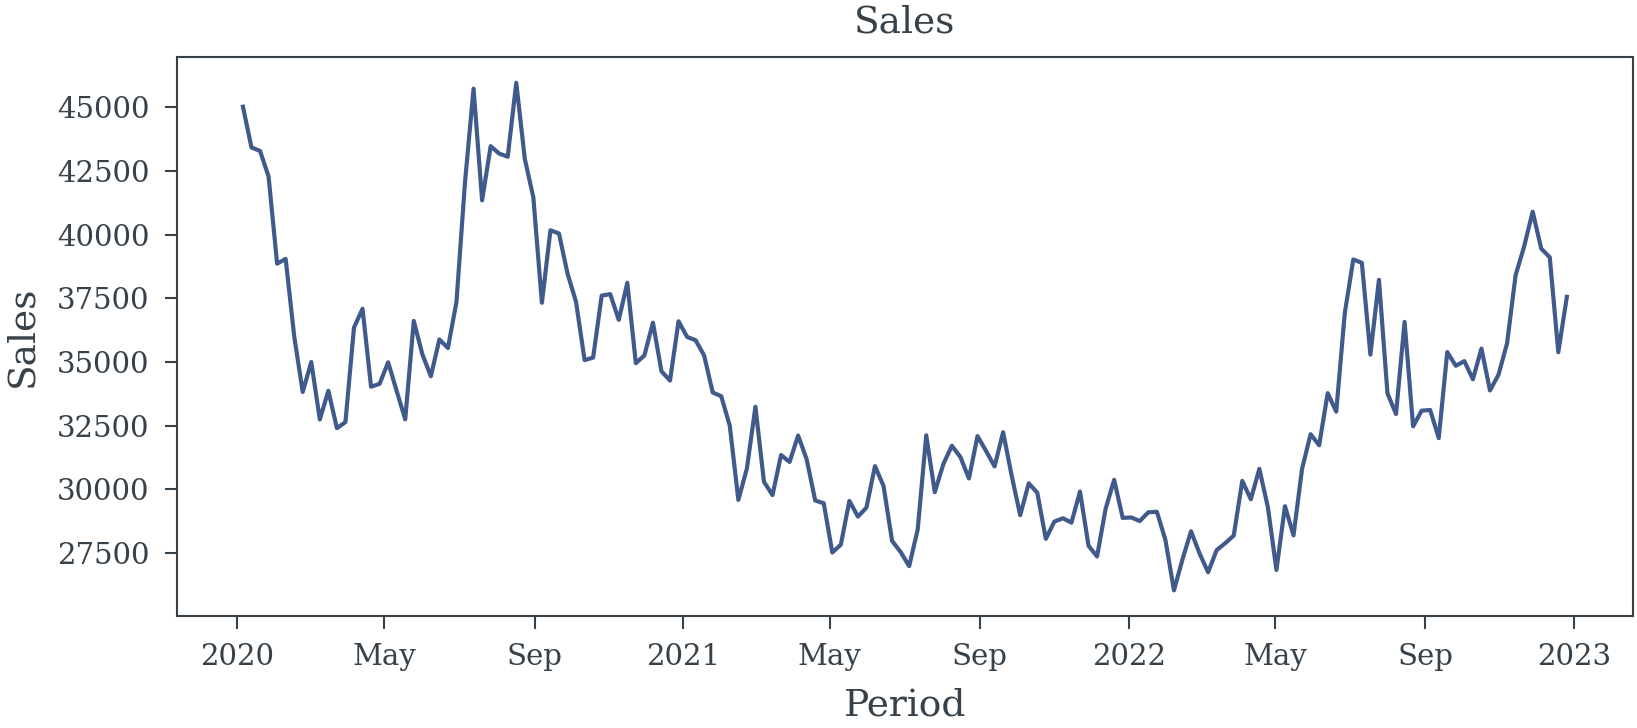

In [16]:
#| echo: false
#| label: fig-simulated-sales
#| fig-cap: Simulated sales data. See @eq-sales for data generative process
#plt.figure(figsize=(10, 5))
sales.plot(c=rgb_to_hex(rgb.tue_darkblue*256))
plt.ylabel('Sales')
plt.title('Sales');

### The naive model

Let's try ignoring the data generation process and fit a simple linear regression model to the data.

In [17]:
#| echo: false
#| label: tbl-measurement-error
#| tbl-cap: Using estimated awareness to predict sales
naive_model = sm.OLS(log_sales.to_series(), sm.add_constant(trace.estimated_awareness.to_series())).fit(cov_type="HAC", cov_kwds={'maxlags':1})
naive_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              awareness   R-squared:                       0.410
Model:                            OLS   Adj. R-squared:                  0.406
Method:                 Least Squares   F-statistic:                     107.0
Date:                Mon, 18 Nov 2024   Prob (F-statistic):           2.28e-19
Time:                        00:34:29   Log-Likelihood:                 134.53
No. Observations:                 156   AIC:                            -265.1
Df Residuals:                     154   BIC:                            -259.0
Df Model:                           1                                         
Covariance Type:                  HAC                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  10.2522      0.019    546.969      0.000      10.215      10.289
estimated_awareness    12.1210      1.172     10.343      0.000       9.824      14.418
==============================================================================
Omnibus:                        3.398   Durbin-Watson:                   1.022
Prob(Omnibus):                  0.183   Jarque-Bera (JB):                3.451
Skew:                           0.344   Prob(JB):                        0.178
Kurtosis:                       2.758   Cond. No.                         142.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 1 lags and without small sample correction
"""

We can see from the results in @tbl-measurement-error that the estimated coefficient is biased. The true coefficient for the effect of the populations ability to recall the brand's advertisement on the brand's sales is 30. The estimated coefficient is much less.

### Next the simple moving average model

Let's try a simple moving average model to see if we can improve the estimate of the coefficient. We will ignore the data generation process and take the moving average of the estimated awareness directly.

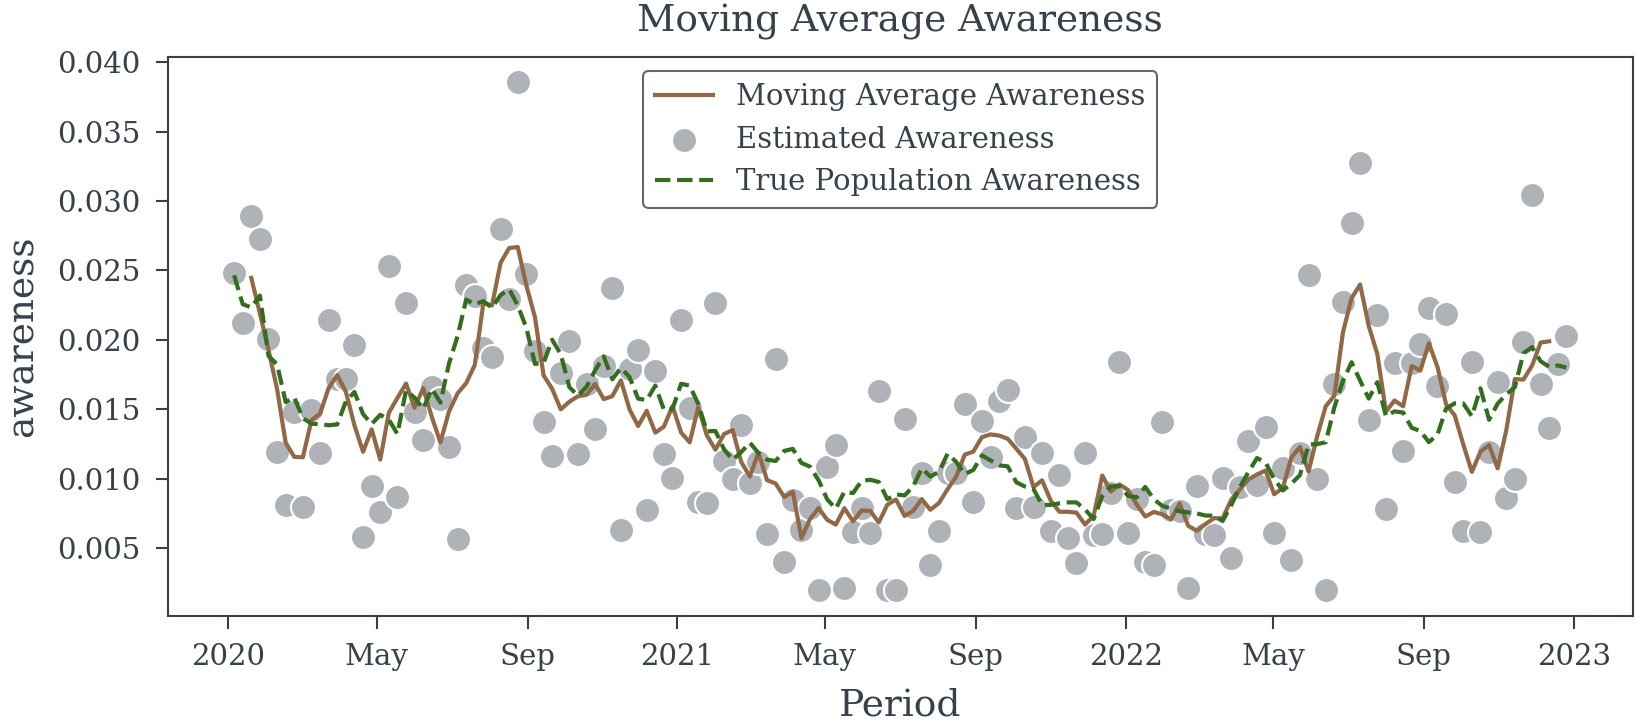

In [18]:
#| echo: false
#| label: fig-mov-avg-awareness-1
#| fig-cap: Moving average awareness
#plt.figure(figsize=(10, 5))
moving_avg_awareness = trace.estimated_awareness.rolling(Period=5).mean().shift(Period=-2)
moving_avg_awareness.plot(
    c=rgb_to_hex(rgb.tue_brown*256), 
    label='Moving Average Awareness')
trace.estimated_awareness.plot.scatter(
    c=rgb_to_hex(rgb.tue_gray*256), 
    label='Estimated Awareness')
trace['awareness'].plot(
    c=rgb_to_hex(rgb.tue_darkgreen*256), 
    ls='--', 
    label='True Population Awareness'
    )
plt.legend()
plt.title('Moving Average Awareness');

In [19]:
#| echo: false
#| label: tbl-moving-avg-model
#| tbl-cap: Using moving average awareness as a predictor
moving_avg_model = sm.OLS(log_sales.to_series()[2:-2], sm.add_constant(moving_avg_awareness.to_series()[2:-2])).fit(cov_type="HAC", cov_kwds={'maxlags':1})
moving_avg_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              awareness   R-squared:                       0.741
Model:                            OLS   Adj. R-squared:                  0.740
Method:                 Least Squares   F-statistic:                     318.2
Date:                Mon, 18 Nov 2024   Prob (F-statistic):           6.66e-39
Time:                        00:34:32   Log-Likelihood:                 196.96
No. Observations:                 152   AIC:                            -389.9
Df Residuals:                     150   BIC:                            -383.9
Df Model:                           1                                         
Covariance Type:                  HAC                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  10.1019      0.016    615.351      0.000      10.070      10.134
estimated_awareness    23.4003      1.312     17.837      0.000      20.829      25.972
==============================================================================
Omnibus:                        0.894   Durbin-Watson:                   0.788
Prob(Omnibus):                  0.639   Jarque-Bera (JB):                0.577
Skew:                           0.129   Prob(JB):                        0.749
Kurtosis:                       3.158   Cond. No.                         209.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 1 lags and without small sample correction
"""

We can see from @tbl-moving-avg-model that we are doing better than the naive model. The estimated coefficient is closer to the true coefficient. However, the estimated coefficient is still biased.

### Moving Average (Correctly this time)

Let's try a moving average model again, but this time we will take the moving average of the number of survey participants and the number of positive results before dividing each.

In [20]:
moving_sum_n_positive = trace.n_positive.rolling(Period=5).sum().shift(Period=-2)
moving_sum_n_participants = trace.n_survey_participants.rolling(Period=5).sum().shift(Period=-2)
moving_avg_awareness = moving_sum_n_positive/moving_sum_n_participants

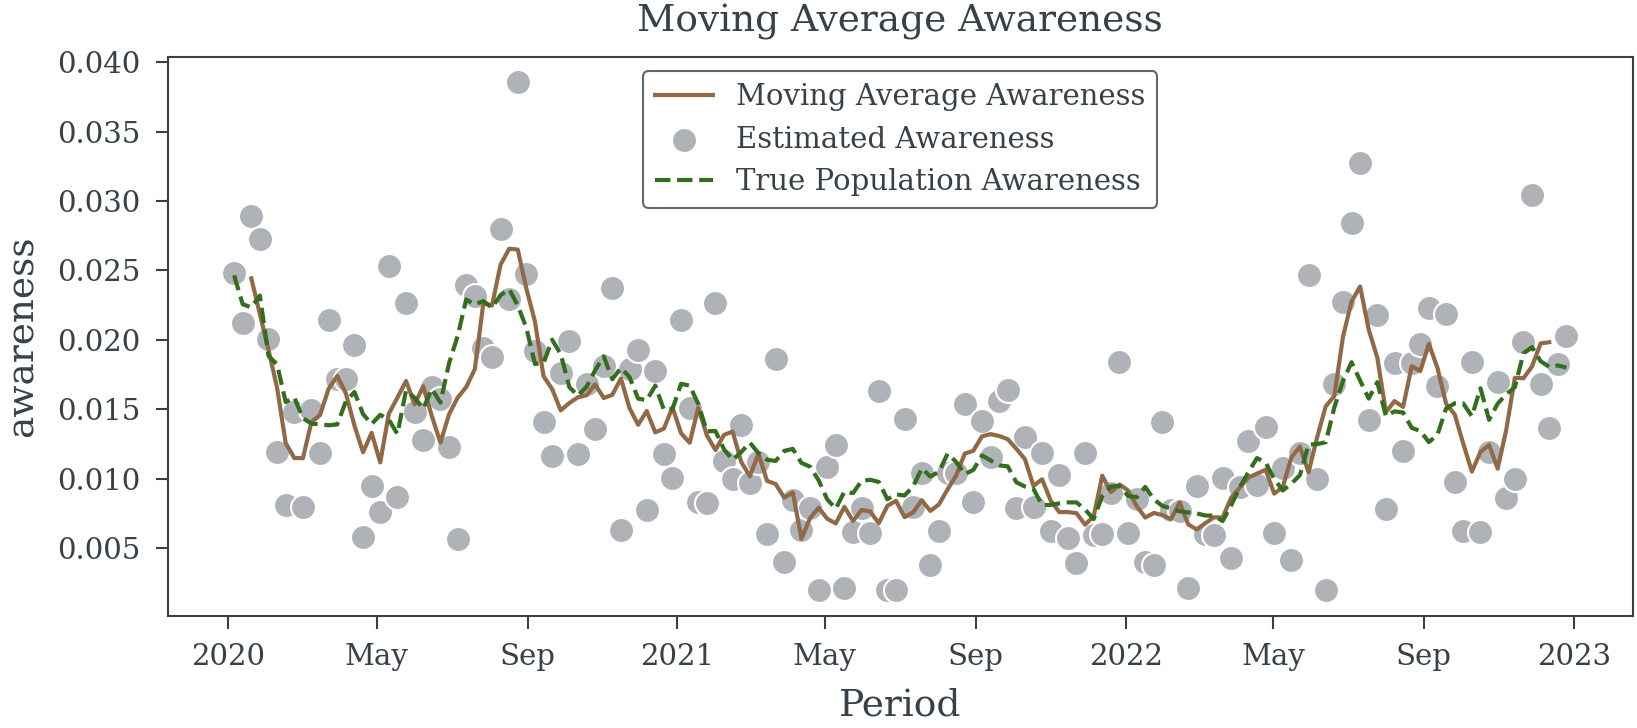

In [21]:
#| echo: false
#| label: fig-mov-avg-awareness-2
#| fig-cap: Moving average awareness second approach
moving_avg_awareness.plot(c=rgb_to_hex(rgb.tue_brown*256), label='Moving Average Awareness')
trace.estimated_awareness.plot.scatter(c=rgb_to_hex(rgb.tue_gray*256),  label='Estimated Awareness')
trace['awareness'].plot(c=rgb_to_hex(rgb.tue_darkgreen*256), ls='--', label='True Population Awareness')
plt.legend()
plt.title('Moving Average Awareness');

In [22]:
#| echo: false
#| label: tbl-corrected-moving-avg
#| tbl-cap: Corrected Moving Average Model
moving_avg_model = sm.OLS(log_sales.to_series()[2:-2], sm.add_constant(moving_avg_awareness.to_dataframe("Moving Avg Awareness")[2:-2])).fit(cov_type="HAC", cov_kwds={'maxlags':1})
moving_avg_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              awareness   R-squared:                       0.740
Model:                            OLS   Adj. R-squared:                  0.738
Method:                 Least Squares   F-statistic:                     327.9
Date:                Mon, 18 Nov 2024   Prob (F-statistic):           1.41e-39
Time:                        00:34:36   Log-Likelihood:                 196.47
No. Observations:                 152   AIC:                            -388.9
Df Residuals:                     150   BIC:                            -382.9
Df Model:                           1                                         
Covariance Type:                  HAC                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   10.1006      0.016    617.023      0.000      10.069      10.133
Moving Avg Awareness    23.5425      1.300     18.109      0.000      20.994      26.091
==============================================================================
Omnibus:                        1.628   Durbin-Watson:                   0.781
Prob(Omnibus):                  0.443   Jarque-Bera (JB):                1.198
Skew:                           0.171   Prob(JB):                        0.549
Kurtosis:                       3.268   Cond. No.                         210.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 1 lags and without small sample correction
"""

This model (@tbl-corrected-moving-avg) is only slightly better than the simple moving average model. The estimated coefficient is still biased.

### Latent Variable Model
Let us now try to first estimate the population level awareness using a bayesian model and then use the estimated population level awareness in the regression model.

In [23]:
#| output: false
dates = trace["Period"].values
awareness_model = random_walk_awareness_model(dates)

with awareness_model as survey_model:
    survey_obs_model(awareness_model['awareness'], avg_weekly_participants=500, coords={'Period': dates})
    
with pm.observe(
  pm.do(
    survey_model, 
    {'n_survey_participants': trace.n_survey_participants.values} # apply the number of survey participants
    ), 
  {'n_positive': trace.n_positive.values} # observe the number of positive responses
  ):
    obs_trace = pm.sample(random_seed=42)

Sampling 4 chains, 0 divergences ━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00 / 0:00:240:00:01 / 0:00:240:00:23


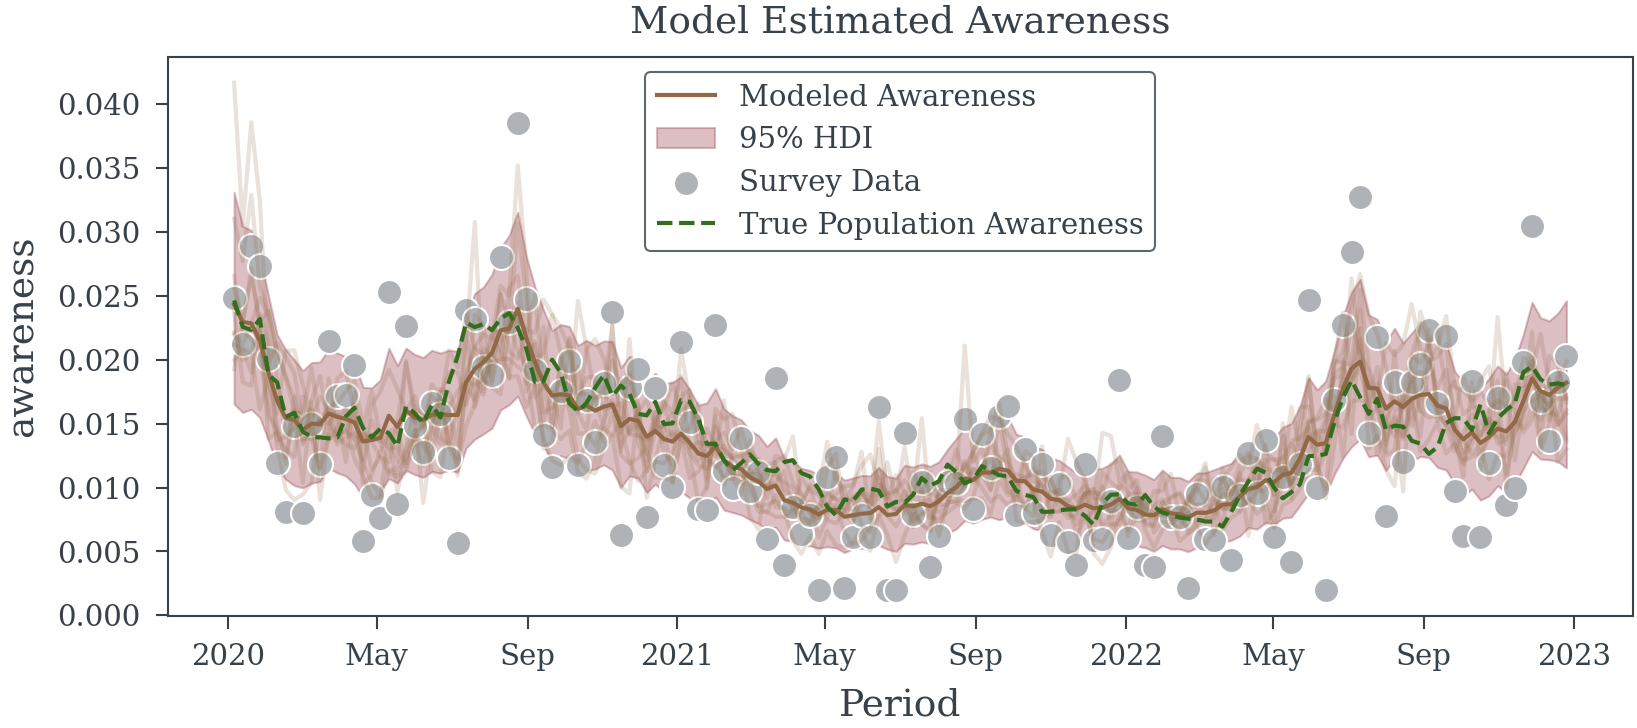

In [24]:
#| echo: false
#| label: fig-modeled-awareness
#| fig-cap: Modeled Awareness
#plt.figure(figsize=(10, 5))
obs_hdi = pm.hdi(obs_trace.posterior['awareness'], hdi_prob=0.95).awareness
(obs_trace
    .posterior['awareness']
    .mean(dim=('draw','chain'))
    .plot(
        c=rgb_to_hex(rgb.tue_brown*256), 
        label='Modeled Awareness')
    )
plt.fill_between(
    obs_hdi.Period, 
    obs_hdi.sel(hdi='lower'), 
    obs_hdi.sel(hdi='higher'), 
    color=rgb_to_hex(rgb.tue_red*256), 
    alpha=0.3, 
    label='95% HDI'
    )
(
obs_trace
    .posterior['awareness']
    .isel(chain=0, draw=slice(0, 100, 10))
    .plot(
        x='Period', 
        hue='draw', 
        color=rgb_to_hex(rgb.tue_brown*256), 
        alpha=0.2
    )
)
(
    trace['estimated_awareness']
    .plot
    .scatter(
        c=rgb_to_hex(rgb.tue_gray*256), 
        label='Survey Data'
        )
)
(
    trace['awareness']
    .plot(
        c=rgb_to_hex(rgb.tue_darkgreen*256), 
        ls='--', 
        label='True Population Awareness'
    )
)
plt.title('Model Estimated Awareness')
plt.legend();

In [25]:
#| echo: false
#| label: tbl-modeled-awareness
#| tbl-cap: Using modeled awareness to estimate sales
estimated_model = sm.OLS(
    log_sales.to_series(), 
    sm.add_constant(
        obs_trace
        .posterior['awareness']
        .mean(dim=('chain', 'draw'))
        .to_series())
    ).fit(
        cov_type="HAC", 
        cov_kwds={'maxlags':1}
    )
estimated_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              awareness   R-squared:                       0.835
Model:                            OLS   Adj. R-squared:                  0.833
Method:                 Least Squares   F-statistic:                     636.8
Date:                Mon, 18 Nov 2024   Prob (F-statistic):           1.39e-56
Time:                        00:35:11   Log-Likelihood:                 233.70
No. Observations:                 156   AIC:                            -463.4
Df Residuals:                     154   BIC:                            -457.3
Df Model:                           1                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         10.0276      0.015    665.156      0.000       9.998      10.057
awareness     28.9124      1.146     25.235      0.000      26.667      31.158
==============================================================================
Omnibus:                        1.670   Durbin-Watson:                   0.961
Prob(Omnibus):                  0.434   Jarque-Bera (JB):                1.331
Skew:                           0.036   Prob(JB):                        0.514
Kurtosis:                       3.447   Cond. No.                         238.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 1 lags and without small sample correction
"""

Compared to the previous models the Latent Variable Model is much better at recovering the ground truth. While the estimated coefficient is still biased (we haven't removed all the measurement error), it is much closer to the true coefficient, than the previous models. Given that the model can be train quickly on the data and the estimated coefficient is much closer to the true coefficient, using the latent model is a good choice.

### Using the true awareness

Finally, let's see how well we can do if we use the true awareness in the regression model. This is not likely to be possible in practice, but it should provide a good comparison point.

In [26]:
#| echo: false
#| label: tbl-true-awareness
#| tbl-cap: Using true awareness to estimate sales
true_model = sm.OLS(
    log_sales.to_series(), 
    sm.add_constant(trace['awareness'].to_series())
    ).fit(
        cov_type="HAC", 
        cov_kwds={'maxlags':1}
    )
true_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              awareness   R-squared:                       0.952
Model:                            OLS   Adj. R-squared:                  0.952
Method:                 Least Squares   F-statistic:                     3171.
Date:                Mon, 18 Nov 2024   Prob (F-statistic):          1.20e-104
Time:                        00:35:11   Log-Likelihood:                 330.05
No. Observations:                 156   AIC:                            -656.1
Df Residuals:                     154   BIC:                            -650.0
Df Model:                           1                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         10.0034      0.008   1249.968      0.000       9.988      10.019
awareness     29.9196      0.531     56.311      0.000      28.878      30.961
==============================================================================
Omnibus:                        5.753   Durbin-Watson:                   2.080
Prob(Omnibus):                  0.056   Jarque-Bera (JB):                5.310
Skew:                          -0.401   Prob(JB):                       0.0703
Kurtosis:                       3.417   Cond. No.                         231.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 1 lags and without small sample correction
"""

Here we see that not only is the estimate spot on, but the standard error is also much lower than the other models. The better the measure of the exogenous variable, the more precise the estimate of the coefficient we can achieve.

In [27]:
#| hide
import nbdev; nbdev.nbdev_export()